In [1]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import * 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
import pandas as pd

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator

#### Interpolate between every 2nd peak and plot residual of remaining peaks with interpolated function 

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:70: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


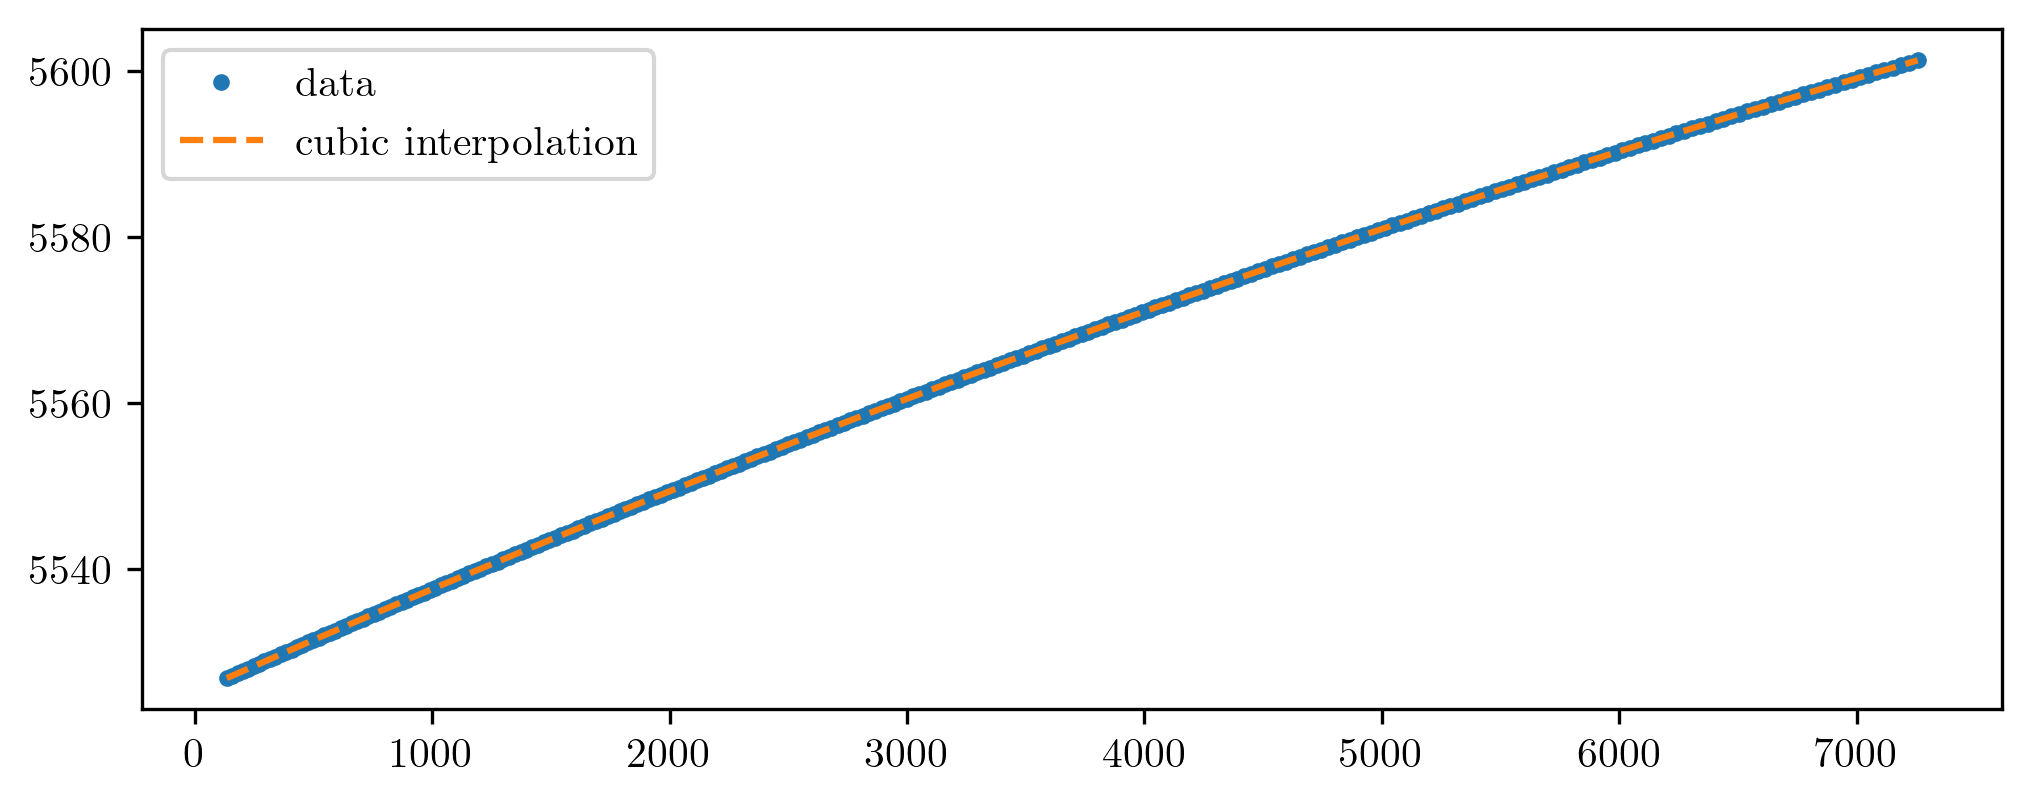

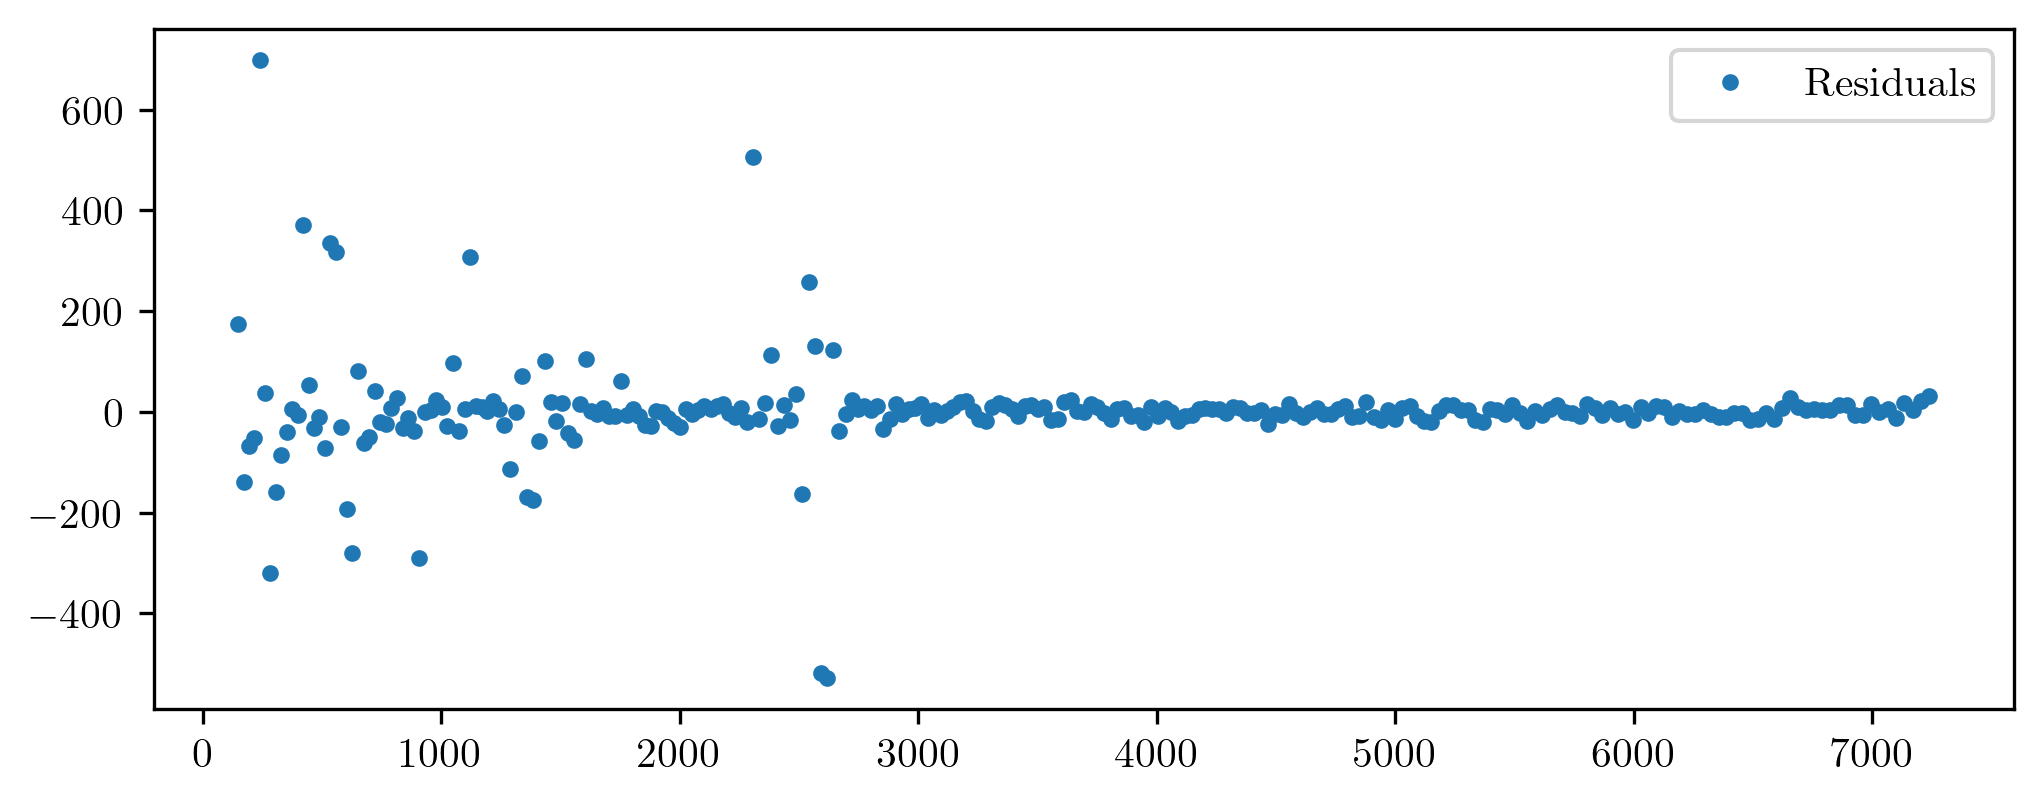

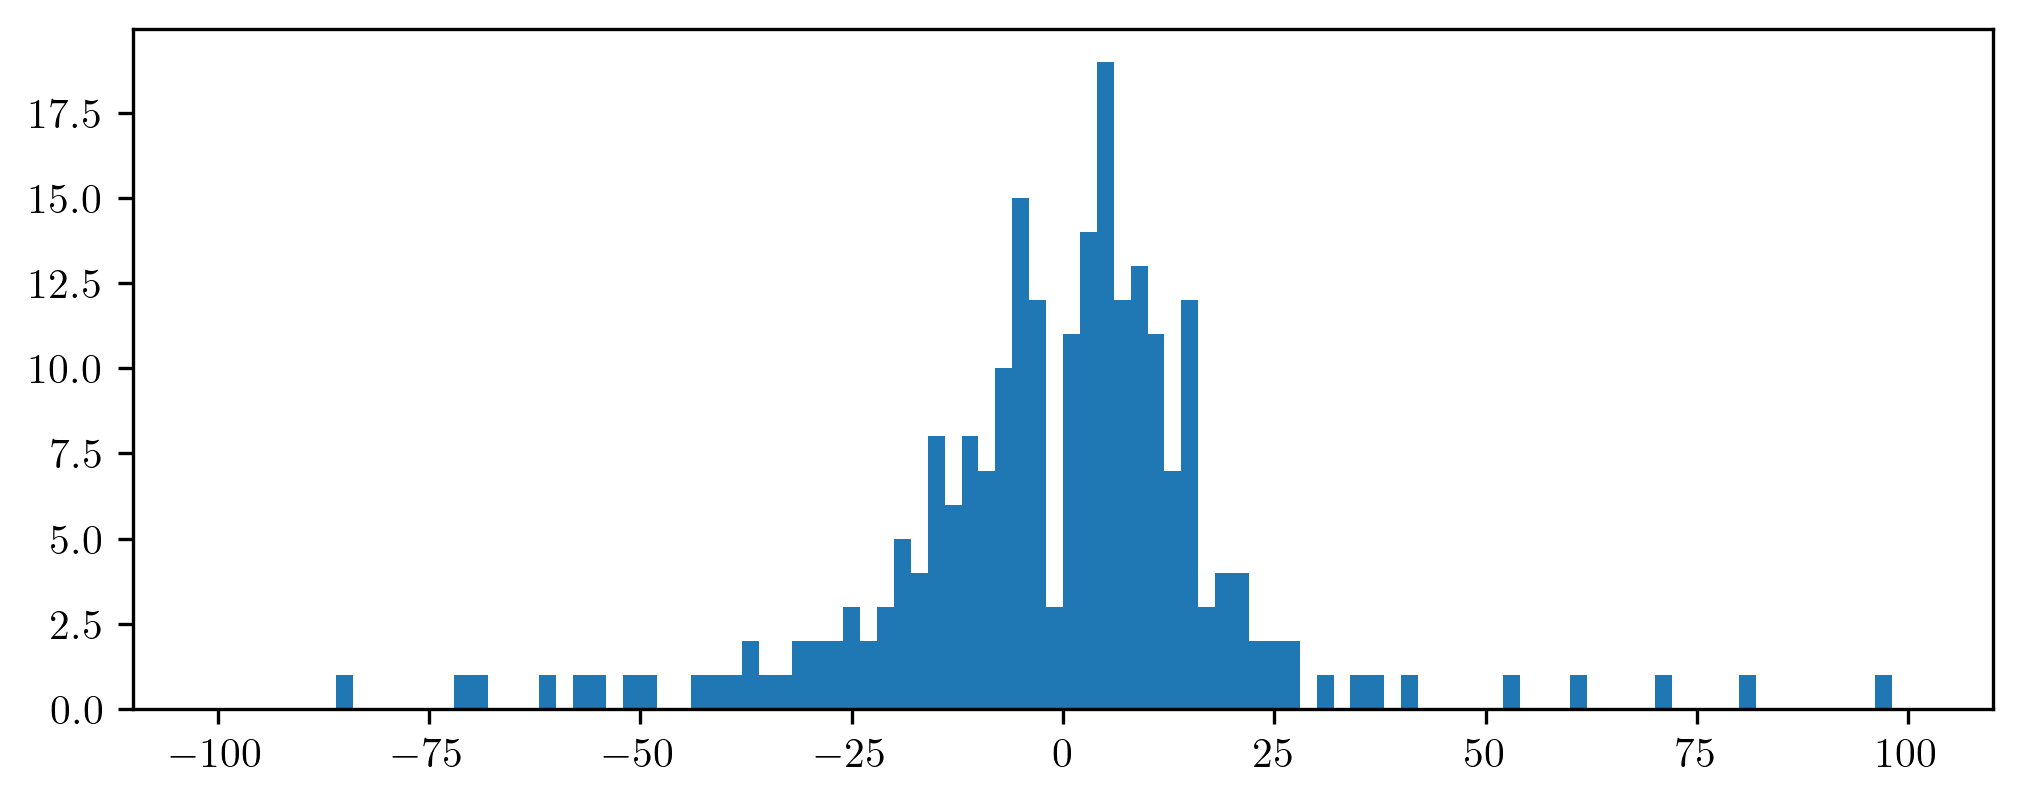

In [55]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 50
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs, peak_range_size = 14)    # TODO: find dynamic way of choosing range size

# Fit peak in each data slice
peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

# Get list of true wavelengths
wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

# Take every other element
x = peak_fits[:,2][::2]
y = wavel_true[::2]

f2 = interp1d(x, y, kind='cubic')
xnew = np.linspace(min(x), max(x), 1000, endpoint=True)

plt.figure(figsize=(8,3))
plt.plot(x, y, '.', xnew, f2(xnew), '--')
plt.legend(['data', 'cubic interpolation'], loc='best')

# Residuals for all x and y
plt.figure(figsize=(8,3))
x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones)
y = wavel_true[1::2]
c = 299792458 # m/s
residuals = (f2(x) - y)/y * c
plt.plot(x, residuals, ".")
plt.legend(['Residuals'], loc='best')

# Plot residuals as hist
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=100, range=(-100, 100));

#### Do interpolation for all peaks, by using every 2nd and flipping around 

$
\text{RMS/line} \left[\mathrm{m} \mathrm{s}^{-1}\right]=\sqrt{\sum_{n=1}^{N} \sum_{p=1}^{P} \frac{\left[\frac{\left(\lambda_{n, p, \text { pred. }}-\lambda_{p, \text { theory }}\right)}{\lambda_{p, \text { theory }}} \times c\right]^{2}}{N \times P}}
$

In [42]:
order, peak_fits, wavel_true, _ = results[50]

cols = ['A', "A_err", "mu", 'mu_err', 'sigma', 'sigma_err', 'c', 'c_err', "chi2", 'ndof', 'converged', 'index_start', 'index_end', 'p-value', 'P', 'P_err']
peak_fits_df = pd.DataFrame(peak_fits, columns=cols)

chi2_mask = (peak_fits_df.chi2 < 100)



515


460

In [3]:
def compute_res(list, list_y_theory, list_y_predicted, peak_fitting_results, omit_first=False, nth_peak=2, plot_orders=None, pchip=False):
    for r in peak_fitting_results:

        order, peak_fits, wavel_true, _ = r

        # Filter by chi2
        cols = ['A', "A_err", "mu", 'mu_err', 'sigma', 'sigma_err', 'c', 'c_err', "chi2", 'ndof', 'converged', 'index_start', 'index_end', 'p-value', 'P', 'P_err']
        peak_fits_df = pd.DataFrame(peak_fits, columns=cols)
        chi2_mask = (peak_fits_df.chi2 < 100)
        peak_fits = peak_fits[chi2_mask]
        wavel_true = wavel_true[chi2_mask]

        # Skip if out of peaks... 
        if len(peak_fits) < 1:
            print("yoooo no peaks ")
            continue 

        if omit_first:
            order, peak_fits, wavel_true = order, peak_fits[1:], wavel_true[1:]

        # Take every other element
        x_interp = peak_fits[:,2][::nth_peak]
        y_interp = wavel_true[::nth_peak][:, 0]

        if pchip:
            f2 = PchipInterpolator(x_interp, y_interp)
        else:
            f2 = interp1d(x_interp, y_interp, kind='cubic') # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

        # Residuals for all x and y
        x_remain = peak_fits[:,2][1::nth_peak] # Take every other element starting at index 1 (so we get the other ones), and skip last item
        y_remain = wavel_true[1::nth_peak][:, 0]
        x_remain = x_remain[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
        y_remain = y_remain[1:-1]
        
        y_predicted = f2(x_remain)

        # res = y_predicted - y # residuals
        c = 299792458 # m/s
        res = (y_predicted - y_remain)/y_remain * c
        list.append(res)
        list_y_theory.append(y_remain)
        list_y_predicted.append(y_predicted)

        # print(o, "max res is", max(res))

        if plot_orders is not None and (plot_orders == order).any():
            fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,4))
            ax1.plot(x_interp, y_interp, ".", label="Interpoalted data points")
            # ax1.plot(x, y, ".", ms=5, label="Tested")
            ax2.plot(x_remain, res, ".", label="Residuals")
            ax1.legend()
            ax2.legend()



def compute_interp_residuals(peak_fitting_results, pchip=False):
    residuals = []
    y_theory = []
    y_predicted = []

    # Compute 1st half
    compute_res(residuals, y_theory, y_predicted, peak_fitting_results, pchip=pchip)

    # Compute 2nd half by skipping first item
    compute_res(residuals, y_theory, y_predicted, peak_fitting_results, pchip=pchip, omit_first=True)

    # Collapse to one list
    residuals = np.concatenate(residuals)

    y_theory = np.concatenate(y_theory)
    y_predicted = np.concatenate(y_predicted)

    return residuals, y_theory, y_predicted

def compute_interp_residuals_for_all_files():
    
    LFC_files = get_files_in_dir(LFC_PATH, "LFC")
    
    residuals = []
    y_theory = []
    y_predicted = []
    
    for file in tqdm(LFC_files):
        fit_results = fit_all_peaks_in_all_orders(file, correct_errors=True)
        interp_results = compute_interp_residuals(fit_results)
        residuals.append(interp_results[0])
        y_theory.append(interp_results[1])
        y_predicted.append(interp_results[2])
    
    return residuals, y_theory, y_predicted
    

In [48]:
results = fit_all_peaks_in_all_orders(correct_errors=True)

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


$
\text{RMS/line} \left[\mathrm{m} \mathrm{s}^{-1}\right]=\sqrt{\sum_{n=1}^{N} \sum_{p=1}^{P} \frac{\left[\frac{\left(\lambda_{n, p, \text { pred. }}-\lambda_{p, \text { theory }}\right)}{\lambda_{p, \text { theory }}} \times c\right]^{2}}{N \times P}}
$

In [8]:
count = 0
for r in results:
    count = count + len(r[1])
count

17068

In [10]:
residuals, y_theory, y_predicted = compute_interp_residuals(results, pchip=False)

# np.savetxt("fit_results/residuals_sqrt1.csv", residuals, delimiter=",")

c = 299792458

summer = ((y_predicted - y_theory)/y_theory * c) ** 2 / len(y_theory)
line_rms = np.sqrt(np.sum(summer))

x = residuals - np.mean(residuals)
standard_rms = np.sqrt(np.sum(x ** 2) / len(x - 1))

line_rms, standard_rms

(10.011997259323635, 10.011995510917203)

Text(0, 0.5, 'Frequency')

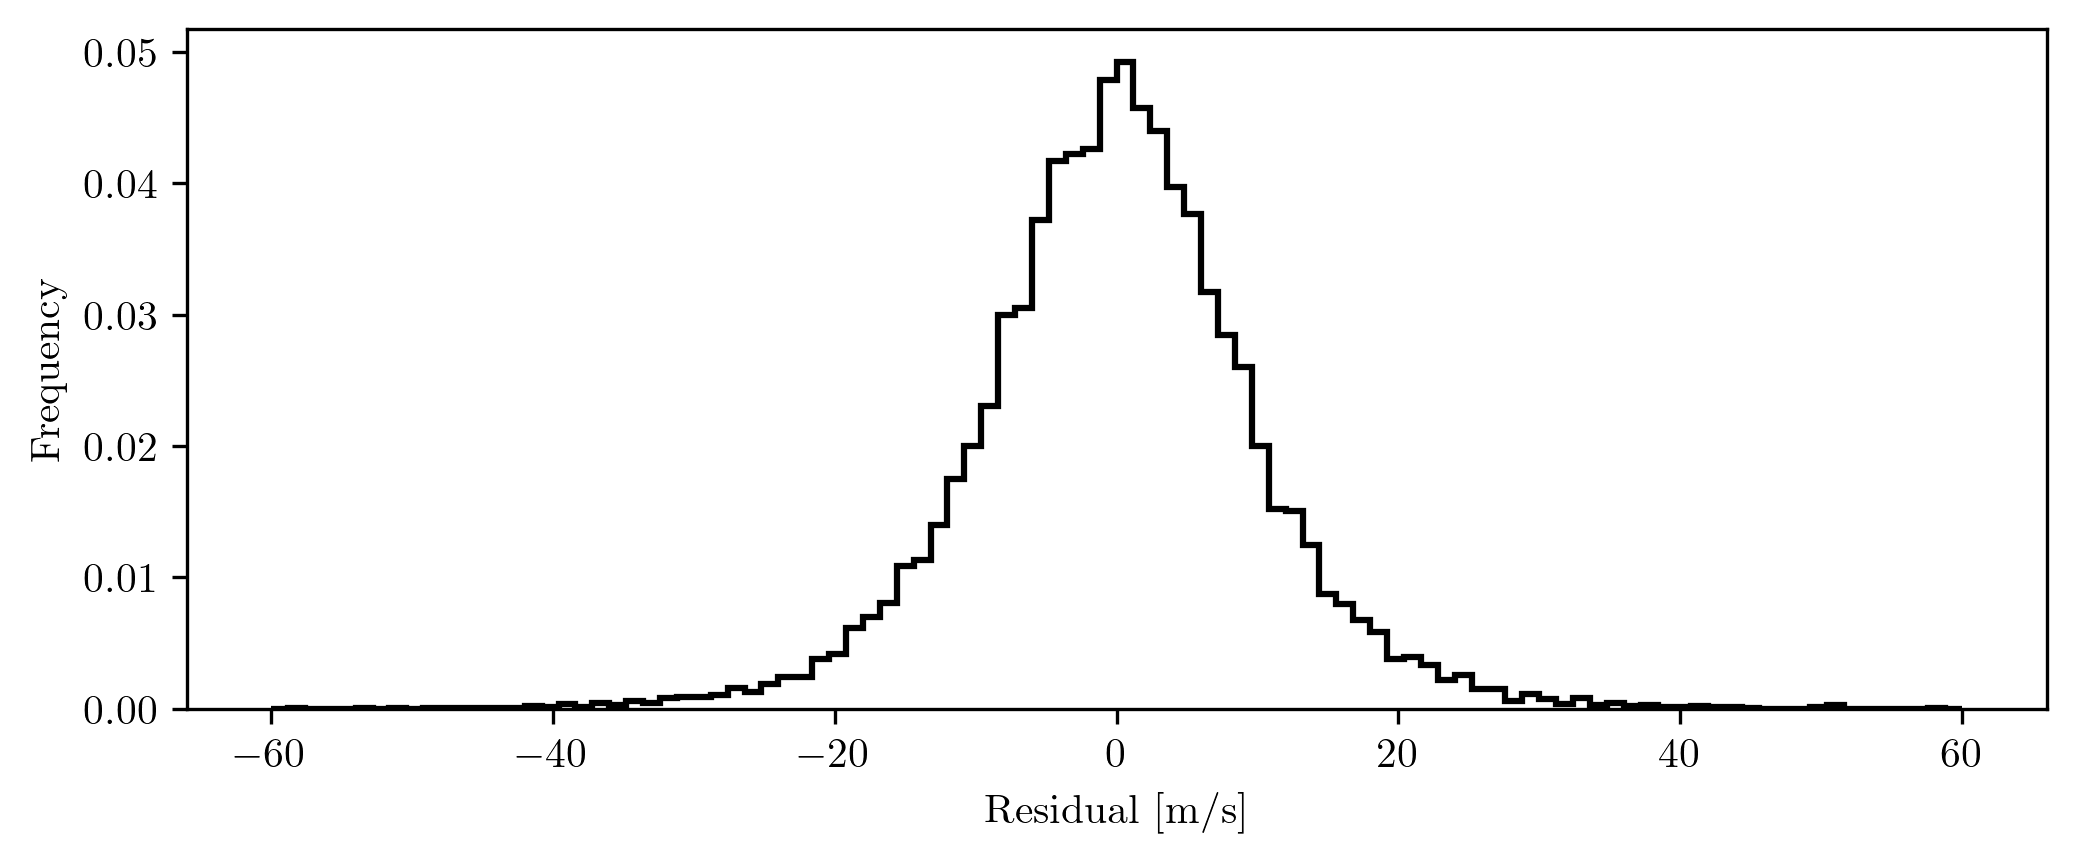

In [49]:
# Plot
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=100, range=(-60, 60), density=True, histtype="step", color="k", lw=1.5);
plt.xlabel("Residual [m/s]")
plt.ylabel("Frequency")

##### Computing rms/line to compare with excalibur

$
\text{RMS/line} \left[\mathrm{m} \mathrm{s}^{-1}\right]=\sqrt{\sum_{n=1}^{N} \sum_{p=1}^{P} \frac{\left[\frac{\left(\lambda_{n, p, \text { pred. }}-\lambda_{p, \text { theory }}\right)}{\lambda_{p, \text { theory }}} \times c\right]^{2}}{N \times P}}
$

#### Compute for all exposures

In [4]:
all_residuals = compute_interp_residuals_for_all_files()


  0%|          | 0/10 [00:00<?, ?it/s]/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:71: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
100%|██████████| 10/10 [06:58<00:00, 41.85s/it]


In [27]:
df = pd.DataFrame(np.column_stack([np.concatenate(all_residuals[0]), np.concatenate(all_residuals[1]), np.concatenate(all_residuals[2])]), columns=["residual", "y_theory", "y_predicted"])
# df.to_csv("fit_results/all_residuals_interp_pd.csv", index=False)
# Read: df1 = pd.read_csv("fit_results/all_residuals_interp_pd.csv")
df

,residual,y_theory,y_predicted
0,-18.277129,5067.569799,5067.569490
1,2.538645,5068.049541,5068.049584
2,13.685832,5068.409407,5068.409638
3,8.435551,5068.769324,5068.769467
4,-5.962588,5069.249294,5069.249193
...,...,...,...
161710,36.515622,7245.035413,7245.036295
161711,-6.506602,7245.770864,7245.770706
161712,22.309184,7246.506464,7246.507003
161713,-22.914056,7246.996947,7246.996393


In [28]:
c = 299792458

summer = ((df.y_predicted - df.y_theory)/df.y_theory * c) ** 2 / len(df.y_theory)
line_rms = np.sqrt(np.sum(summer))

x = df.residual - np.mean(df.residual)
standard_rms = np.sqrt(np.sum(x ** 2) / len(x - 1))

line_rms, standard_rms

(15.13524447056914, 15.135244314276584)

#### Plot LFC lines with color

100%|██████████| 300/300 [00:01<00:00, 185.20it/s]


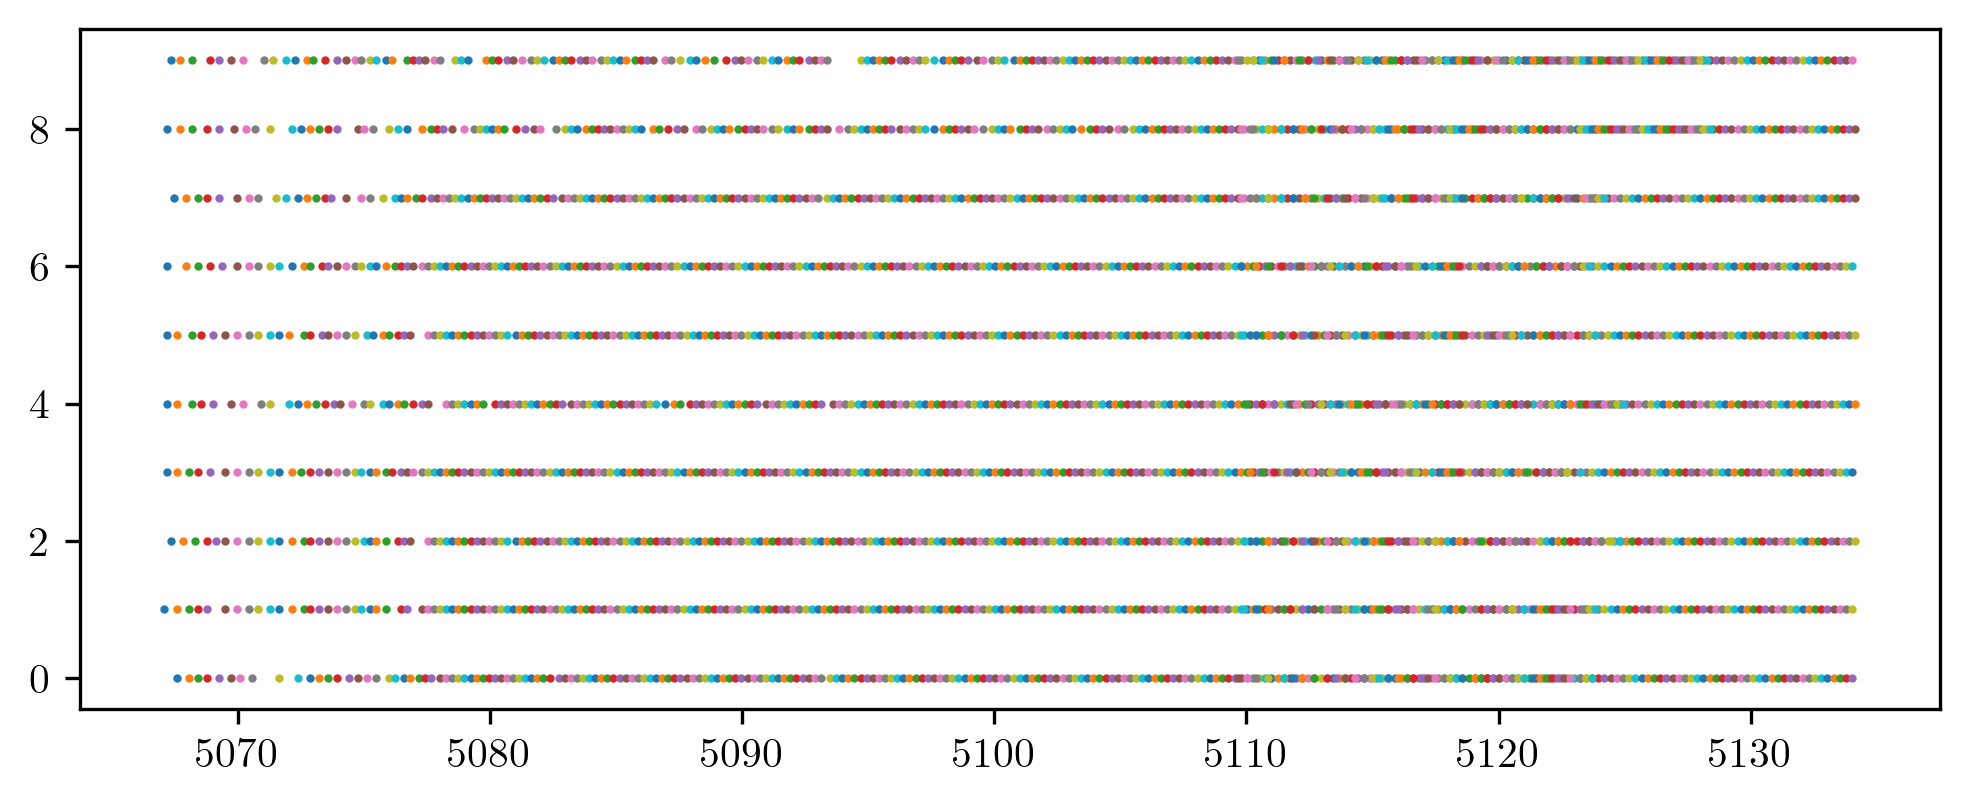

In [75]:
from color_spec import *

# ColourSystem.spec_to_rgb(300)

plt.figure(figsize=(8,3))
for res, y_t, y_p, index in zip(all_residuals[0], all_residuals[1], all_residuals[2], np.arange(len(all_residuals[0]))):
    for y in tqdm(y_p[:300]):
        plt.scatter(y, index, s=1)





### Compare to 6 degree poly fit // PLOT IN REPORT

Polyfit:
17068 points, min = -6.704477357677572e+17, max = 4.6130964282129325e+17
Interp:
17032 points, min = -78.37242234366386, max = 55.90654935657585


Text(0.5, 29.76801370673775, 'Residuals [Å]')

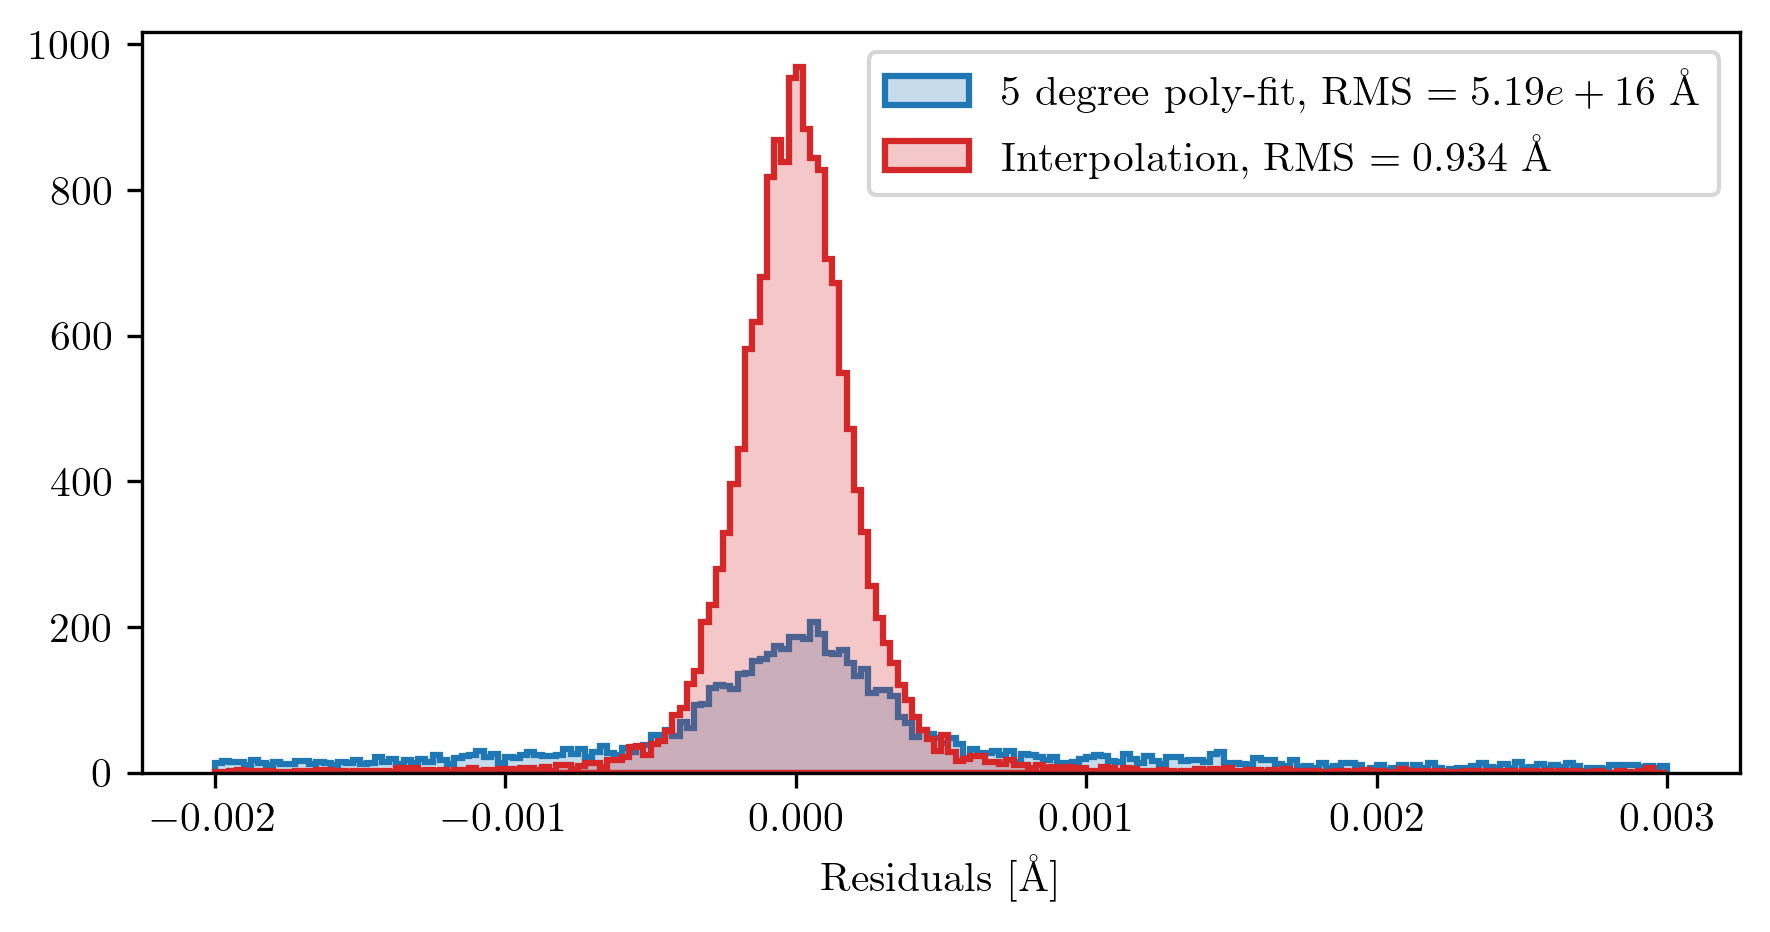

In [73]:
from matplotlib import colors

def compute_rms(x):
    x = x - np.mean(x)
    return np.sqrt(np.sum(x ** 2) / len(x - 1))

def print_res_info(res):
    res_min, res_max = np.nanmin(res), np.nanmax(res)
    res_len = len(res)
    print(f"{res_len} points, min = {res_min}, max = {res_max}")


res_fit5 = np.genfromtxt("fit_results/residuals_5degree_sqrt3_new.csv")
res_interp = np.genfromtxt("fit_results/residuals_interp_all_peaks_every_2nd_flipped_with_errors_sqrt3.csv")

print("Polyfit:")
print_res_info(res_fit5)

print("Interp:")
print_res_info(res_interp)

plt.figure(figsize=(6, 3))
mRange = (-0.002, 0.003)
plt.hist(res_fit5, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C0', 0.25), edgecolor="C0", lw=1.5, label=f"5 degree poly-fit, RMS $ = {compute_rms(res_fit5):.3}$ Å");
plt.hist(res_interp, bins=200, range=mRange, histtype="stepfilled", facecolor=colors.to_rgba('C3', 0.25), edgecolor="C3", lw=1.5, label=f"Interpolation, RMS $ = {compute_rms(res_interp):.3}$ Å");
plt.legend(loc="upper right")
plt.tight_layout()
plt.xlabel("Residuals [Å]")

# plt.savefig("hist_peak_residuals_poly_and_interp.pdf", bbox_inches="tight", dpi=300)

#### New one with m/s

Polyfit 5 : 16546 points, min = -14409859083.092703, max = 7762146272.774614
Interp: : 16366 points, min = -63.06716494824425, max = 85.96928425191474


(-100.0, 100.0)

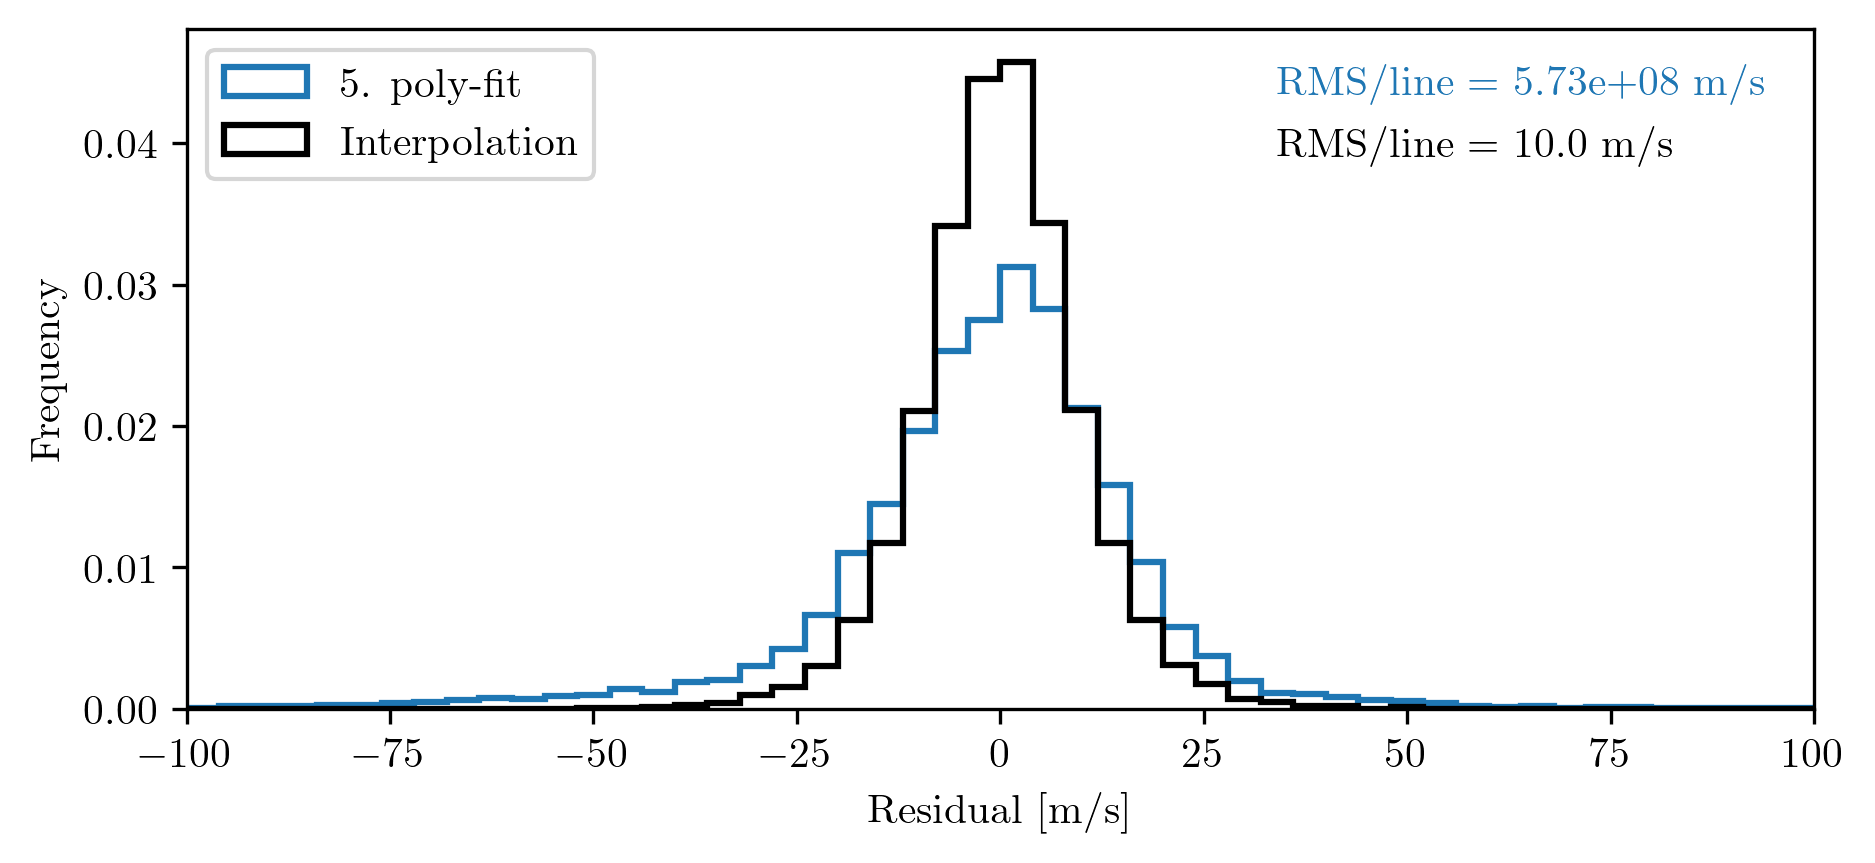

In [208]:
from matplotlib import colors

def compute_rms(x):
    x = x - np.mean(x)
    return np.sqrt(np.sum(x ** 2) / len(x - 1))

def print_res_info(title, res):
    res_min, res_max = np.nanmin(res), np.nanmax(res)
    res_len = len(res)
    print(f"{title} : {res_len} points, min = {res_min}, max = {res_max}")

res_fit5 = np.genfromtxt("fit_results/residuals_5degree_sqrt3_ms_chi2sorted.csv")
res_interp = np.genfromtxt("fit_results/residuals_interp_all_peaks_every_2nd_flipped_with_errors_sqrt3_ms_chi2sorted.csv")

print_res_info("Polyfit 5", res_fit5)
print_res_info("Interp:", res_interp)

fig, ax = plt.subplots(figsize=(7,3))
mRange = (-200, 200)

ax.hist(res_fit5, bins=100, range=mRange, histtype="step",
            edgecolor="C0", lw=1.5, label=f"5. poly-fit", density=True);

ax.hist(res_interp, bins=100, range=mRange, histtype="step",
            edgecolor="k", lw=1.5, label=f"Interpolation", density=True);

ax.text(0.67, 0.95, f"RMS/line = {compute_rms(res_fit5):.3} m/s", color="C0", fontweight="500",
            size = 10, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

ax.text(0.67, 0.86, f"RMS/line = {compute_rms(res_interp):.3} m/s", color="k", fontweight="500",
            size = 10, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

ax.set_xlabel("Residual [m/s]")
ax.set_ylabel("Frequency")
ax.legend(loc="upper left")
ax.set_xlim(-100, 100)
# ax.tight_layout()

# plt.savefig("latex/figures/calib/hist_peak_residuals_poly_and_interp.pdf", bbox_inches="tight", dpi=300)

### Save interpolation function for calibration use

In [105]:
# for o in range(40, 76):
o = 45
order, peak_fits, wavel_true, data_wavel = results[o]

# Take every other element
x = peak_fits[:,2][::2]
y = wavel_true[::2][:, 0]

f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

f2(4032)

# Save scipy object
np.save(f"fit_results/interp_order{o}.npy", f2, allow_pickle=True)

# To load scipy object
# f3 = np.load("fit_results/interpolation.sci.npy", allow_pickle=True).item(0)


#### Compute interpolation sigma for different error correction factors

In [82]:
# Include interpolation sigma check
def compute_interp_sigma(results):

    def compute_res(list, omit_first=False):
        for o in range(40, 76):

            order, peak_fits, wavel_true, data_wavel = results[o]
            
            if omit_first:
                order, peak_fits, wavel_true, data_wavel = order, peak_fits[1:], wavel_true[1:], data_wavel[1:]

            # Take every other element
            x = peak_fits[:,2][::2]
            y = wavel_true[::2][:, 0]

            f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate") # fill_value="extrapolate" is used to extrapolate to reach the last items outside (last item in list)

            # Residuals for all x and y
            x = peak_fits[:,2][1::2] # Take every other element starting at index 1 (so we get the other ones), and skip last item
            y = wavel_true[1::2][:, 0]
            # x = x[1:-1]  # first and last data points don't work well — exclude them ... TODO ?
            # y = y[1:-1]
            
            res = f2(x) - y # residuals
            list.append(res)



    residuals = []

    # Compute 1st half
    compute_res(residuals)

    # Compute 2nd half by skipping first item
    compute_res(residuals, omit_first=True)
    # Collapse to one list
    residuals = np.concatenate(residuals)
    
    return np.std(residuals)


sigmas = []
for s in tqdm.tqdm(np.arange(2, 8)):
    results = fit_all_peaks_in_all_orders(correct_errors=True, custom_error_factor=np.sqrt(s))
    sigma = compute_interp_sigma(results)
    sigmas.append(sigma)


  0%|          | 0/6 [00:00<?, ?it/s]/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:89: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:89: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
100%|██████████| 6/6 [04:29<00:00, 44.96s/it]


In [86]:
# plt.figure(figsize=(16,8))
# plt.plot(np.arange(2,8), sigmas, ".")

sigmas

[39.21483928899965,
 0.9336073845515256,
 41.83899076181079,
 1.7719583535378467,
 35.65157776732648,
 0.33645499266916423]